<a href="https://colab.research.google.com/github/MehwishSameer/Book-Recommendation-System/blob/master/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import string
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
nltk.download('stopwords')
nltk.download('wordnet')
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
users = pd.read_csv("/content/drive/My Drive/Users.csv")
ratings = pd.read_csv("/content/drive/My Drive/Ratings.csv")
books = pd.read_csv ("/content/drive/My Drive/books.txt")
books.to_csv (r'/content/drive/My Drive/books.csv', index=None)

### **1. Data-Cleaning:**

In [ ]:
users.dropna()
books.dropna()
ratings.dropna()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [ ]:
users.drop_duplicates()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [ ]:
books.drop_duplicates()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,"Bayou Moon (The Edge, #2)",eng,4.09,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,"Means of Ascent (The Years of Lyndon Johnson, #2)",eng,4.25,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,The Mauritius Command,eng,4.35,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,Cinderella Ate My Daughter: Dispatches from th...,eng,3.65,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


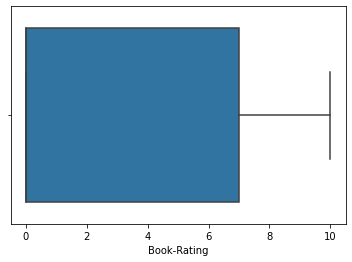

In [ ]:
ratings['Book-Rating'].describe()
sns.boxplot(ratings['Book-Rating'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


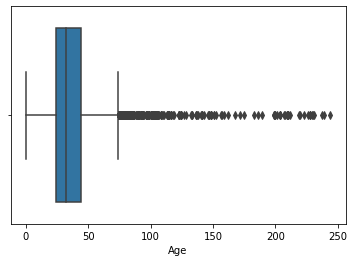

In [ ]:
users['Age'].describe()
sns.boxplot(users['Age'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


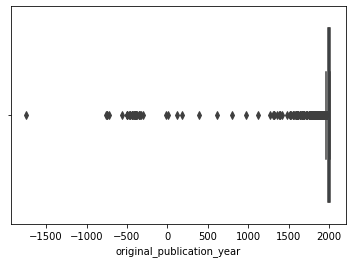

In [ ]:
books['original_publication_year'].describe()
sns.boxplot(books['original_publication_year'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


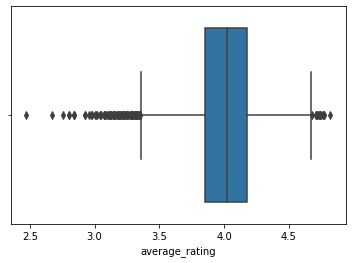

In [ ]:
books['average_rating'].describe()
sns.boxplot(books['average_rating'])

Unusual Outliers are found in the **age** field of users and in the **original_publication_year** field of books.

In [ ]:
users = users[users['Age'] > 0]
users.drop(users.index[users['Age'] < 0], inplace=True)
users['Age'].describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


count    167680.000000
mean         34.837649
std          14.341649
min           1.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

In [ ]:
stop_w=nltk.corpus.stopwords.words('english')
def clean_str(str):
    str="".join([x for x in str if x not in string.punctuation])
    tokens=re.split('\W+',str)
    str=[x for x in tokens if x not in stop_w]
    return str

In [ ]:
books['title_clean']=books['title'].apply(lambda x: clean_str(x.lower()))
books.head(5)

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,title_clean
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"[hunger, games, hunger, games, 1]"
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,"[harry, potter, sorcerers, stone, harry, potte..."
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,"[twilight, twilight, 1]"
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,"[kill, mockingbird]"
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,"[great, gatsby]"


*   Data Lemmatizing:

In [ ]:
ds=nltk.WordNetLemmatizer()
def data_lem(str):
   str=[ds.lemmatize(word) for word in str]
   return str

In [ ]:
books['title_clean_1']=books['title_clean'].apply(lambda x: data_lem(x))
users=pd.merge(users,ratings,on='User-ID',how='outer')
users.head(5)

,User-ID,Location,Age,ISBN,Book-Rating
0,2,"stockton, california, usa",18.0,0195153448,0.0
1,4,"porto, v.n.gaia, portugal",17.0,NaN,NaN
2,6,"santa monica, california, usa",61.0,NaN,NaN
3,10,"albacete, wisconsin, spain",26.0,1841721522,0.0
4,10,"albacete, wisconsin, spain",26.0,8477024456,6.0


### **2. Content Based Recommendation Using TF-IDF:**

In [ ]:
vect=TfidfVectorizer(analyzer=clean_str,ngram_range=(1,3))
vect1=vect.fit_transform(books['title'])
vect_df = pd.DataFrame(vect1.toarray(), columns=vect.get_feature_names())
vect_df.head(5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,,0,01,0105,02,03,04,05,06,07,08,09,1,10,100,1000,101,101st,10th,11,110,112,112263,113,11YearOld,11th,12,121,125,12Day,12th,13,1324,135,13½,14,1421,145,1491,1493,...,في,قلبي,قمر,قيلا,كخه,كشك,كفر,كل,لا,لي,ليتها,ما,ماهی,متوقعة,محال,مخطوطة,مدينة,مردگان,مع,مما,من,نادي,نسيان,هشت,هيبتا,واحة,وستاربكس,يا,يليق,ينبغي,يوتوبيا,يوم,ڤيرتيجو,کتاب,کوچولو,یک,キスよりも早く1,ナルト,巻ノ四十三,美少女戦士セーラームーン新装版
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.198229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sim=sigmoid_kernel(vect1,vect1)
sim

array([[0.76163776, 0.76159486, 0.76159526, ..., 0.76159542, 0.76159416,
        0.76159575],
       [0.76159486, 0.76163776, 0.76159524, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159526, 0.76159524, 0.76163776, ..., 0.76159416, 0.76159416,
        0.76159416],
       ...,
       [0.76159542, 0.76159416, 0.76159416, ..., 0.76163776, 0.76159416,
        0.76159549],
       [0.76159416, 0.76159416, 0.76159416, ..., 0.76159416, 0.76163776,
        0.76159416],
       [0.76159575, 0.76159416, 0.76159416, ..., 0.76159549, 0.76159416,
        0.76163776]])

In [ ]:
books=books.dropna(subset=['title'])
movies=pd.Series(books.index,index=books['title']).drop_duplicates()
movies

title
The Hunger Games (The Hunger Games, #1)                                                         0
Harry Potter and the Sorcerer's Stone (Harry Potter, #1)                                        1
Twilight (Twilight, #1)                                                                         2
To Kill a Mockingbird                                                                           3
The Great Gatsby                                                                                4
                                                                                             ... 
Bayou Moon (The Edge, #2)                                                                    9995
Means of Ascent (The Years of Lyndon Johnson, #2)                                            9996
The Mauritius Command                                                                        9997
Cinderella Ate My Daughter: Dispatches from the Frontlines of the New Girlie-Girl Culture    9998
The First Worl

In [ ]:
def reccom(title,sim=sim):
  r=movies[title]
  score=list(enumerate(sim[r]))
  score=sorted(score,key=lambda x:x[1],reverse=True)
  score=score[1:6]
  score=[i[0] for i in score]
  return books['title'].iloc[score]

**Implementation**:

In [ ]:
reccom('The First World War')

6563                                               War
3412                                First Things First
3696                  The Heroes (First Law World, #5)
8179                                        First Love
238     World War Z: An Oral History of the Zombie War
Name: title, dtype: object

### **2. Popularity Based Recommendation:**

In [ ]:
rate=users[users['ISBN'].isin(books['isbn'])]
print(rate.shape)
print(users.shape)

(116762, 5)
(1255501, 5)


In [ ]:
users=users[users['Book-Rating']!=0]
users=users[users['ISBN'].isin(books['isbn'])]
users=users.dropna(subset=['Book-Rating','ISBN'])
users.shape

(4747, 5)

In [ ]:
users=pd.DataFrame(users.groupby(['ISBN'])['Book-Rating'].sum())
popular=users.sort_values('Book-Rating',ascending=False).head(10)
books.rename(columns={'isbn': 'ISBN'}, inplace=True)
users=users.merge(books,left_index=True,right_on='ISBN')
users.head(10)

,Book-Rating,id,book_id,best_book_id,work_id,books_count,ISBN,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,title_clean,title_clean_1
2668,3.0,2669,45100,45100,1476156,56,000649885X,9.780006e+12,Robin Hobb,1998.0,Ship of Magic,"Ship of Magic (Liveship Traders, #1)",eng,4.12,37381,43191,1647,501,1564,7308,16594,17224,https://images.gr-assets.com/books/1360507722m...,https://images.gr-assets.com/books/1360507722s...,"[ship, magic, liveship, traders, 1]","[ship, magic, liveship, trader, 1]"
6501,7.0,6502,316845,316845,2457438,70,000675399X,9.780007e+12,T.H. White,1938.0,The Sword in the Stone,The Sword in the Stone (The Once and Future Ki...,eng,3.92,17104,19482,624,440,1111,4525,6965,6441,https://images.gr-assets.com/books/1355212194m...,https://images.gr-assets.com/books/1355212194s...,"[sword, stone, future, king, 1]","[sword, stone, future, king, 1]"
4648,15.0,4649,99296,99296,301388,16,006000150X,9.780060e+12,"Doreen Cronin, Harry Bliss",1996.0,Diary of a Worm,Diary of a Worm,eng,4.19,23320,23423,691,322,987,4006,6599,11509,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,"[diary, worm]","[diary, worm]"
8592,34.0,8593,39933,39933,39635,35,006000942X,9.780060e+12,Thomas C. Foster,2003.0,NaN,How to Read Literature Like a Professor: A Liv...,en-US,3.63,12467,14587,1764,524,1332,4212,5409,3110,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,"[read, literature, like, professor, lively, en...","[read, literature, like, professor, lively, en..."
6042,19.0,6043,702539,702539,2504855,53,006008216X,9.780060e+12,Elmore Leonard,1990.0,Get Shorty,"Get Shorty (Chili Palmer, #1)",eng,3.95,15747,16863,505,164,663,3832,7374,4830,https://images.gr-assets.com/books/1330673682m...,https://images.gr-assets.com/books/1330673682s...,"[get, shorty, chili, palmer, 1]","[get, shorty, chili, palmer, 1]"
5088,68.0,5089,764903,764903,1925199,82,006008460X,9.780060e+12,"Frank B. Gilbreth Jr., Ernestine Gilbreth Carey",1948.0,Cheaper by the Dozen,Cheaper by the Dozen,eng,3.99,26266,28494,1557,355,1284,6465,10435,9955,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,"[cheaper, dozen]","[cheaper, dozen]"
8381,22.0,8382,4813,4813,1788700,40,006054094X,9.780061e+12,Gavin Menzies,2002.0,1421: The Year China Discovered America,1421: The Year China Discovered America,eng,3.58,10200,10971,906,790,1077,2810,3578,2716,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,"[1421, year, china, discovered, america]","[1421, year, china, discovered, america]"
3035,36.0,3036,33441,33441,1684116,32,006056668X,9.780061e+12,Christopher Moore,2003.0,"Fluke: Or, I Know Why the Winged Whale Sings","Fluke: Or, I Know Why the Winged Whale Sings",eng,3.73,32675,33997,1935,575,2584,10228,12515,8095,https://images.gr-assets.com/books/1168444068m...,https://images.gr-assets.com/books/1168444068s...,"[fluke, know, winged, whale, sings]","[fluke, know, winged, whale, sings]"
9450,9.0,9451,68099,68099,1245618,75,006074068X,9.780061e+12,Donna Leon,1992.0,Death at La Fenice,"Death at La Fenice (Commissario Brunetti, #1)",en-US,3.81,11705,14654,1493,151,692,4119,6471,3221,https://images.gr-assets.com/books/1441466744m...,https://images.gr-assets.com/books/1441466744s...,"[death, la, fenice, commissario, brunetti, 1]","[death, la, fenice, commissario, brunetti, 1]"
1796,70.0,1797,2794,2794,1477756,92,006091307X,9.780061e+12,Thomas Pynchon,1966.0,The Crying of Lot 49,The Crying of Lot 49,en-US,3.70,48692,54779,3489,2227,5166,13618,19312,14456,https://images.gr-assets.com/books/1375727632m...,https://images.gr-assets.com/books/1375727632s...,"[crying, lot, 49]","[cry, lot, 49]"


**Implementation:**

In [ ]:
users['title'].head(10)

2668                 Ship of Magic (Liveship Traders, #1)
6501    The Sword in the Stone (The Once and Future Ki...
4648                                      Diary of a Worm
8592    How to Read Literature Like a Professor: A Liv...
6042                        Get Shorty (Chili Palmer, #1)
5088                                 Cheaper by the Dozen
8381              1421: The Year China Discovered America
3035         Fluke: Or, I Know Why the Winged Whale Sings
9450        Death at La Fenice (Commissario Brunetti, #1)
1796                                 The Crying of Lot 49
Name: title, dtype: object